In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from collections import namedtuple
from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import sys
sys.path.append('/home/ryohayama/python_current/BasicFeatureAnalysis')

import feature as F
import feature_collection as FC
import ps.joint_probability as psjp

In [5]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
                if f not in binary_fs
                if f not in categorical_fs])

ind_fs = sorted([f for f in all_fs if '_ind' in f])
calc_fs = sorted([f for f in all_fs if '_calc' in f])
car_fs = sorted([f for f in all_fs if '_car' in f])
reg_fs = sorted([f for f in all_fs if '_reg' in f])

inds = train[ind_fs]
calcs = train[calc_fs]
cars = train[car_fs]
regs = train[reg_fs]

target = train.target

In [15]:
[f for f in ind_fs if 'cat' in f]

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']

In [8]:
# inds
for i, f in enumerate(inds.columns):
    uniques = inds[f].unique()
    num_uniques = len(uniques)
    print('%s, %d unique vals:\n' % (f, num_uniques), sorted(uniques))

ps_ind_01, 8 unique vals:
 [0, 1, 2, 3, 4, 5, 6, 7]
ps_ind_02_cat, 5 unique vals:
 [-1, 1, 2, 3, 4]
ps_ind_03, 12 unique vals:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ps_ind_04_cat, 3 unique vals:
 [-1, 0, 1]
ps_ind_05_cat, 8 unique vals:
 [-1, 0, 1, 2, 3, 4, 5, 6]
ps_ind_06_bin, 2 unique vals:
 [0, 1]
ps_ind_07_bin, 2 unique vals:
 [0, 1]
ps_ind_08_bin, 2 unique vals:
 [0, 1]
ps_ind_09_bin, 2 unique vals:
 [0, 1]
ps_ind_10_bin, 2 unique vals:
 [0, 1]
ps_ind_11_bin, 2 unique vals:
 [0, 1]
ps_ind_12_bin, 2 unique vals:
 [0, 1]
ps_ind_13_bin, 2 unique vals:
 [0, 1]
ps_ind_14, 5 unique vals:
 [0, 1, 2, 3, 4]
ps_ind_15, 14 unique vals:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
ps_ind_16_bin, 2 unique vals:
 [0, 1]
ps_ind_17_bin, 2 unique vals:
 [0, 1]
ps_ind_18_bin, 2 unique vals:
 [0, 1]


In [18]:
ind_cat_fs = [f for f in ind_fs if 'cat' in f]
ind_noncat_fs = [f for f in ind_fs if f not in ind_cat_fs]
ind_cats = train[ind_cat_fs] + 1
ind_noncats = train[ind_noncat_fs]
inds2 = pd.concat([ind_cats, ind_noncats], axis=1)

In [20]:
ind_current_fs = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
               'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin',
               'ps_ind_18_bin', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
ind_noncurrent_fs = [f for f in ind_fs if f not in ind_current]

currents = FC.CategoricalFeatureCollection(inds2[ind_current_fs], target=target).convert2CondProba()
noncurrents = FC.CategoricalFeatureCollection(inds2[ind_noncurrent_fs], target=target).convert2CondProba()

In [22]:
currents.describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448
std,0.006375,0.006413,0.000340,0.000380,0.001464,0.000461,0.005206,0.006944,0.000854,0.003064,0.004669,0.008161
min,0.028537,0.032676,0.036441,0.036432,0.036305,0.036433,0.032718,0.033870,0.036084,0.035725,0.034790,0.033865
25%,0.028537,0.032676,0.036441,0.036432,0.036305,0.036433,0.032718,0.033870,0.036084,0.035725,0.034790,0.033865
50%,0.041585,0.032676,0.036441,0.036432,0.036305,0.036433,0.032718,0.033870,0.036084,0.035725,0.034790,0.033865
75%,0.041585,0.047350,0.036441,0.036432,0.036305,0.036433,0.043714,0.033870,0.036084,0.037217,0.038644,0.033865
max,0.041585,0.047350,0.054054,0.045680,0.051442,0.051418,0.043714,0.055155,0.038453,0.185185,0.397590,0.083319


In [23]:
noncurrents.describe()

,ps_ind_01,ps_ind_03,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448
std,0.003879,0.006241,0.002464,0.001544,0.001498,0.004443
min,0.033221,0.029559,0.035357,0.033211,0.036301,0.030480
25%,0.033221,0.030340,0.035357,0.037184,0.036301,0.030925
50%,0.033629,0.037136,0.035357,0.037184,0.036301,0.038801
75%,0.040316,0.040527,0.035357,0.037184,0.036301,0.039350
max,0.045132,0.062846,0.042012,0.037184,0.200000,0.046053


In [26]:
jpo1 = psjp.JointProbabilityOptimizer(currents, verbose=True)
res1 = jpo1.selectByAddition(noncurrents, target)
pd.DataFrame({'exp_val': res1[0], 'importance_': res1[1]}).sort_values('importance_', ascending=False)

 0/ 6: Processing Original
 1/ 6: Processing with ps_ind_01
 2/ 6: Processing with ps_ind_03
 3/ 6: Processing with ps_ind_08_bin
 4/ 6: Processing with ps_ind_09_bin
 5/ 6: Processing with ps_ind_14
 6/ 6: Processing with ps_ind_15


,exp_val,importance_
ps_ind_15,1360.235591,0.369404
ps_ind_03,1240.009747,0.248368
ps_ind_01,1239.340229,0.247694
ps_ind_08_bin,1013.524425,0.020356
ps_ind_09_bin,1013.524425,0.020356
initial,993.304968,0.000000
ps_ind_14,993.304968,0.000000


In [27]:
currents2 = pd.concat([currents, noncurrents], axis=1)
del currents2['ps_ind_14']

In [29]:
ind_probas = psjp.JointProbability().fit_transform(currents2, target, label='ind_probas')

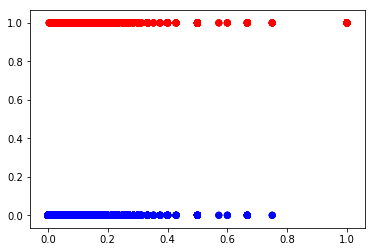

In [30]:
plt.scatter(ind_probas, target, c=target, cmap=cm.bwr)

In [33]:
len(ind_probas.unique())

674

# cars

In [34]:
# cars
for i, f in enumerate(cars.columns):
    uniques = cars[f].unique()
    num_uniques = len(uniques)
    print('%s, %d unique vals:\n' % (f, num_uniques), sorted(uniques))

ps_car_01_cat, 13 unique vals:
 [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ps_car_02_cat, 3 unique vals:
 [-1, 0, 1]
ps_car_03_cat, 3 unique vals:
 [-1, 0, 1]
ps_car_04_cat, 10 unique vals:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ps_car_05_cat, 3 unique vals:
 [-1, 0, 1]
ps_car_06_cat, 18 unique vals:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
ps_car_07_cat, 3 unique vals:
 [-1, 0, 1]
ps_car_08_cat, 2 unique vals:
 [0, 1]
ps_car_09_cat, 6 unique vals:
 [-1, 0, 1, 2, 3, 4]
ps_car_10_cat, 3 unique vals:
 [0, 1, 2]
ps_car_11, 5 unique vals:
 [-1, 0, 1, 2, 3]
ps_car_11_cat, 104 unique vals:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100,

In [52]:
car_cat_fs = [f for f in ind_fs if 'cat' in f]
car_noncat_fs = [f for f in car_fs if f not in car_cat_fs]
car_cats = train[car_cat_fs] + 1
car_noncats = train[car_noncat_fs]
cars2 = pd.concat([car_cats, car_noncats], axis=1)

In [53]:
cars2.columns

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15'],
      dtype='object')

In [54]:
car_current_fs = ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
                  'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
                  'ps_car_11_cat']
car_noncurrent_fs = ['ps_car_11', 'ps_car_15']

In [56]:
car_currents = FC.CategoricalFeatureCollection(cars2[car_current_fs], target=target).convert2CondProba()
car_noncurrents = FC.CategoricalFeatureCollection(cars2[car_noncurrent_fs], target=target).convert2CondProba()

In [57]:
car_currents.describe()

,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448
std,0.007723,0.005912,0.006080,0.007150,0.004269,0.007004,0.006883,0.003812,0.005259,0.000196,0.009377
min,0.028770,0.000000,0.032707,0.021739,0.031709,0.031720,0.034766,0.034735,0.033344,0.034383,0.018423
25%,0.028770,0.033772,0.032707,0.033451,0.031709,0.033373,0.034766,0.034735,0.033344,0.036464,0.028728
50%,0.037549,0.033772,0.032707,0.033451,0.040111,0.034185,0.034766,0.034735,0.036319,0.036464,0.035413
75%,0.041581,0.033772,0.039538,0.033451,0.040454,0.034294,0.034766,0.034735,0.036319,0.036464,0.044913
max,0.317757,0.049507,0.048298,0.093525,0.040454,0.069405,0.078162,0.044933,0.091388,0.039773,0.075110


In [58]:
car_noncurrents.describe()

,ps_car_11,ps_car_15
count,595212.000000,595212.000000
mean,0.036448,0.036448
std,0.003885,0.005908
min,0.000000,0.022897
25%,0.036069,0.032108
50%,0.036069,0.038044
75%,0.038584,0.040082
max,0.047069,0.044395


In [59]:
jpo2 = psjp.JointProbabilityOptimizer(car_currents, verbose=True)
res2 = jpo2.selectByAddition(car_noncurrents, target)
pd.DataFrame({'exp_val': res2[0], 'importance_': res2[1]}).sort_values('importance_', ascending=False)

 0/ 2: Processing Original
 1/ 2: Processing with ps_car_11
 2/ 2: Processing with ps_car_15


,exp_val,importance_
ps_car_15,5203.877727,0.730666
ps_car_11,3239.496179,0.077367
initial,3006.865110,0.000000


In [60]:
car_currents2 = pd.concat([car_currents, car_noncurrents], axis=1)

In [61]:
car_probas = psjp.JointProbability().fit_transform(car_currents2, target, label='ind_probas')

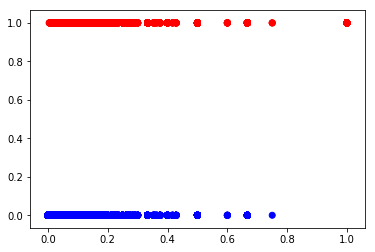

In [62]:
plt.scatter(car_probas, target, c=target, cmap=cm.bwr)

In [70]:
len(car_probas.unique())

641

# calcs

In [74]:
calc_currents = train[['ps_calc_05', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']]

In [75]:
jpo3 = psjp.JointProbabilityOptimizer(calc_currents, verbose=True)
res3 = jpo3.selectByElimination(target)
pd.DataFrame({'exp_val': res3[0], 'importance_': res3[1]}).sort_values('importance_', ascending=False)

 0/ 6: Processing Original
 1/ 6: Processing without ps_calc_05
 2/ 6: Processing without ps_calc_07
 3/ 6: Processing without ps_calc_10
 4/ 6: Processing without ps_calc_12
 5/ 6: Processing without ps_calc_13
 6/ 6: Processing without ps_calc_14


,exp_val,importance_
ps_calc_10,1850.436853,0.704683
ps_calc_14,1895.648917,0.697467
ps_calc_13,2403.682071,0.616388
ps_calc_07,2590.747219,0.586534
ps_calc_12,2876.370906,0.540950
ps_calc_05,2899.530609,0.537254
initial,6265.923969,0.000000


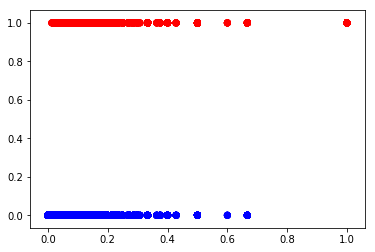

In [76]:
calc_probas = psjp.JointProbability().fit_transform(calc_currents, target, label='calc_probas')
plt.scatter(calc_probas, target, c=target, cmap=cm.bwr)

In [77]:
len(calc_probas.unique())

214

# regs

In [80]:
reg_currents = train[['ps_reg_01', 'ps_reg_02']]

In [81]:
jpo4 = psjp.JointProbabilityOptimizer(reg_currents, verbose=True)
res4 = jpo4.selectByElimination(target)
pd.DataFrame({'exp_val': res4[0], 'importance_': res4[1]}).sort_values('importance_', ascending=False)

 0/ 2: Processing Original
 1/ 2: Processing without ps_reg_01
 2/ 2: Processing without ps_reg_02


,exp_val,importance_
ps_reg_02,806.636520,0.030874
ps_reg_01,822.513054,0.011799
initial,832.333827,0.000000


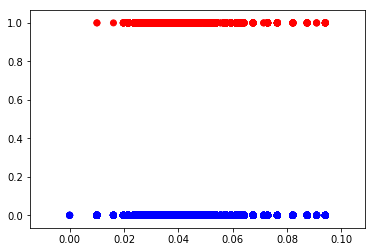

In [82]:
reg_probas = psjp.JointProbability().fit_transform(reg_currents, target, label='calc_probas')
plt.scatter(reg_probas, target, c=target, cmap=cm.bwr)

In [84]:
len(reg_probas.unique())

136

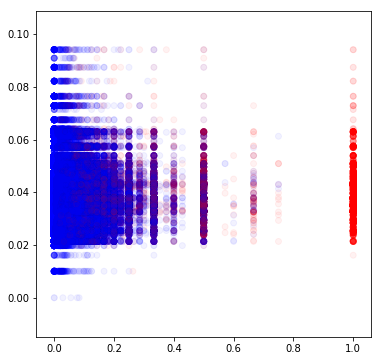

In [85]:
plt.figure(figsize=(6,6))
plt.scatter(ind_probas, reg_probas, c=target, cmap=cm.bwr, alpha=0.05)

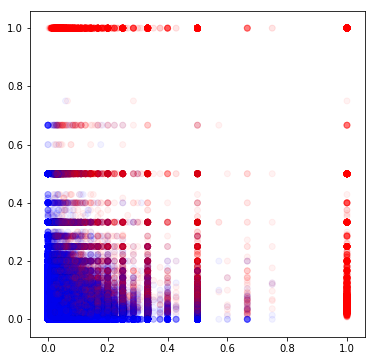

In [65]:
plt.figure(figsize=(6,6))
plt.scatter(ind_probas, car_probas, c=target, cmap=cm.bwr, alpha=0.05)

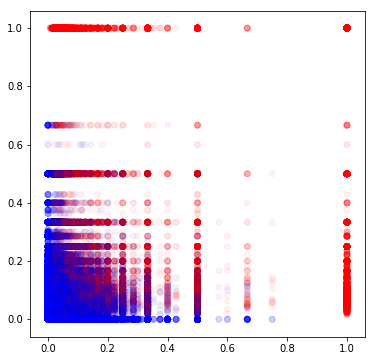

In [78]:
plt.figure(figsize=(6,6))
plt.scatter(ind_probas, calc_probas, c=target, cmap=cm.bwr, alpha=0.05)

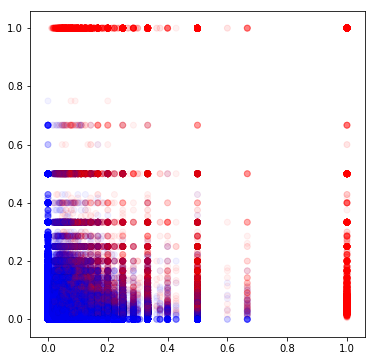

In [79]:
plt.figure(figsize=(6,6))
plt.scatter(calc_probas, car_probas, c=target, cmap=cm.bwr, alpha=0.05)

In [86]:
space = pd.concat([ind_probas, reg_probas, calc_probas, car_probas], axis=1)

In [90]:
y = np.array(train.target)

In [91]:
pca = PCA()
Xpca = pca.fit_transform(np.array(space))

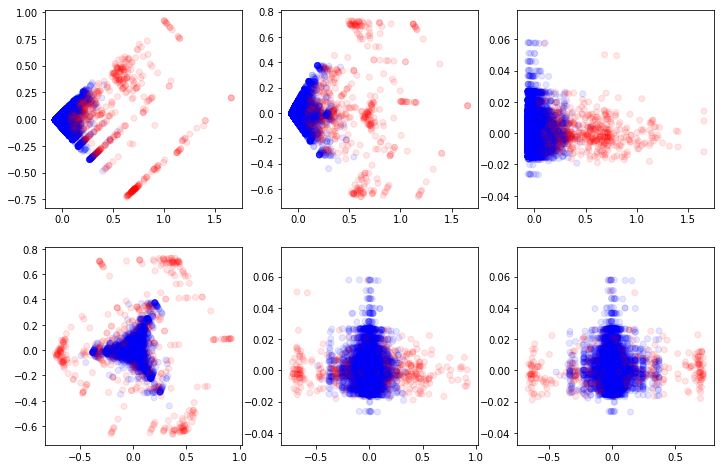

In [92]:
num_plot = 20000
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
ax1.scatter(Xpca[:num_plot, 0], Xpca[:num_plot, 1], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca[:num_plot, 0], Xpca[:num_plot, 2], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca[:num_plot, 0], Xpca[:num_plot, 3], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca[:num_plot, 1], Xpca[:num_plot, 2], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca[:num_plot, 1], Xpca[:num_plot, 3], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
ax6.scatter(Xpca[:num_plot, 2], Xpca[:num_plot, 3], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)